In [1]:
# Let's think of this problem as of monocular visual SLAM problem

In [2]:
import sys
import cv2
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
FPS = 20
FOCAL = 910  # pixels

In [4]:
# List files with videos and velocities
videos_paths = sorted(glob.glob('labeled/*.hevc'))
angles_paths = sorted(glob.glob('labeled/*.txt'))

In [5]:
def load_images_and_angles(video_path: str, angles_path: str):
    '''This function loads images and angles.
    
    TODO
    '''
    imgs = []
    cap = cv2.VideoCapture(video_path)
    dir_x_y = np.loadtxt(angles_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            imgs.append(frame)
        else:
            print('All images read')
            break
    imgs = np.array(imgs)
    cap.release()
    return imgs, dir_x_y

In [6]:
# Load images and angles for the first video
imgs, dir_x_y = load_images_and_angles(videos_paths[0], angles_paths[0])

All images read


In [7]:
# Get intrinsic matrix from resolution and focal lenght. There are no distortion 
# because no distortion coefficients are provided.
H, W = imgs[0].shape[:2]
CX = W / 2
CY = H / 2
K = np.array([[FOCAL,     0, CX], 
              [    0, FOCAL, CY], 
              [    0,     0,  1]])
print('K:', repr(K), sep='\n')

K:
array([[910.,   0., 582.],
       [  0., 910., 437.],
       [  0.,   0.,   1.]])


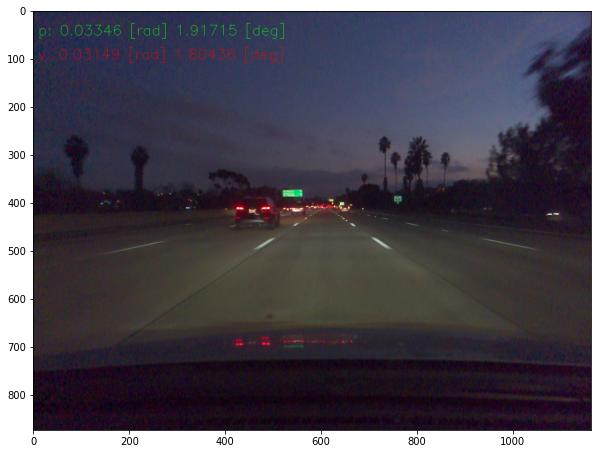

In [8]:
# Visualize single frame

frame_no = 0
frame = imgs[frame_no].copy()
pitch = dir_x_y[frame_no][0]
pitch_deg = np.rad2deg(pitch)
yaw = dir_x_y[frame_no][1]
yaw_deg = np.rad2deg(yaw)
cv2.putText(img=frame,
            text=f'p: {pitch:.5f} [rad] {pitch_deg:.5f} [deg]',
            org=(10, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0))
cv2.putText(img=frame,
            text=f'y: {yaw:.5f} [rad] {yaw_deg:.5f} [deg]',
            org=(10, 100),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 0, 0))
plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()

In [14]:
def feature_detection(image: np.ndarray):
    pts = cv2.goodFeaturesToTrack(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 
                                  maxCorners=3000, qualityLevel=0.01, minDistance=7)
    return pts

def zero_image_part(image: np.ndarray) -> np.ndarray:
    image_cp = image.copy()
    image_cp[:150, :] = [0, 0, 0]
    image_cp[600:, :] = [0, 0, 0]
    return image_cp

In [18]:
# Calculate transforms between previous and current frame

n_features = 0
R = np.zeros((3, 3))
t = np.zeros((3, 1))
poses = [t]
for i in range(1, len(imgs)):
    old_frame = zero_image_part(imgs[i - 1])
    cur_frame = zero_image_part(imgs[i])
    if n_features < 2000:
        p0 = feature_detection(old_frame)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_frame, cur_frame, p0, None)
    good_old = p0[st == 1]
    good_new = p1[st == 1]

    if i < 2:
        E, _ = cv2.findEssentialMat(good_new, good_old, K)
        _, R, t, _ = cv2.recoverPose(E, good_old, good_new, K, R, t)
    else:
        E, _ = cv2.findEssentialMat(good_new, good_old, K)
        _, R, t, _ = cv2.recoverPose(E, p0, p1, K, R.copy(), t.copy())
    n_features = good_new.shape[0]    
    poses.append(t)

poses = np.array(poses)    